
# Productividad de pozos

Analisis estadístico y simulación de gasto en pozos. 

Información de producción histórica de hidrocarburos de la CNH.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import scipy.stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from datetime import datetime, timedelta,date
%matplotlib inline

import timeit

import warnings

plt.style.use('seaborn-white')

In [2]:
pd.set_option('display.max_rows', 100_000_000)
pd.set_option('display.max_columns', 100_000_000)
pd.set_option('display.width', 1_000)
pd.set_option('precision', 2)
pd.options.display.float_format = '{:,.2f}'.format

warnings.filterwarnings("ignore")

# Función Carga de BD

In [3]:
def carga_bd():
    
    global mx_bd
    
    tic=timeit.default_timer()
    
    mx_bd=pd.read_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/mexico/mx_bd.csv',
                          usecols=['fecha',
                                  'pozo',
                                  'aceite_Mbd',
                                  'gas_asociado_MMpcd',
                                  'gas_no_asociado_MMpcd',
                                  'condensado_Mbd',
                                  'agua_Mbd',
                                  'estado actual',
                                  'profundidad_total',
                                  'profundidad_vertical',
                                  'trayectoria', 
                                  'ano_perforacion',
                                  'hidrocarburo',
                                  'clasificacion',
                                  'disponible',
                                  'campo',
                                  'cuenca', 
                                  'entidad',  
                                  'ubicacion',
                                  'asignacion'],
                             low_memory=False)
    
    toc=timeit.default_timer()
    tac= toc - tic #elapsed time in seconds

    return display('Tiempo de procesamiento: ' +str(tac)+' segundos')

In [4]:
carga_bd()

'Tiempo de procesamiento: 29.122087299999997 segundos'

# Función Productividad de pozos

In [70]:
def productividad(hidrocarburo):
    
    global unique_well_list
    global data_pozos
    global resultados
    global gasto_aceite
    global perfil
    global df
    
    tic=timeit.default_timer()
    
    
#############      ESTADISTICA DE POZOS   ####### 
    
    #input de campo de analisis
    def campo_analisis():
        
        global campo
        global input_campo
        global intervalos
    
        #Input de campo
        input_campo = input("Nombre de campo: ")
        intervalos = 3

        seleccion=mx_bd.pozo.str.contains(str(input_campo))
        campo=mx_bd.loc[seleccion]

        unique_well_list=pd.unique(campo['pozo'])

        display('Número de pozos en ' +str(input_campo)+': '+str(len(unique_well_list)))
           
        #Estadistica descriptiva
        display('Percentiles y estadistica descriptiva: ')
        display(campo[hidrocarburo].quantile([.1,.5,.9]),
                campo.describe())  
        
        #Analisis de dispersion
        campo=campo.sort_values(by='profundidad_total',ascending=True)
        fig, ax = plt.subplots(figsize=(10,5))
        ax.scatter(campo[hidrocarburo],campo.profundidad_total,color='Black')
        plt.title('Gasto de '+str(hidrocarburo)+' vs profundidad total para el campo '+str(input_campo))
        ax.set_xlabel(hidrocarburo)
        ax.set_ylabel('Profundidad total')
        plt.show()

        #Generacion de archivo de resultados
        campo.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/'+str(input_campo)+str('.csv'))

        return campo
    

########      ANALISIS DE DECLINACION DE POZOS      ####### 
    
    def remove_nan_and_zeroes_from_columns(df, variable):
        """
        This function cleans up a dataframe by removing rows in a specific 
        column that are null/NaN or equal to 0. This basically removes zero 
        production time periods.
        Arguments:
        df: Pandas dataframe.
        variable: String. Name of the column where we want to filter out
        NaN's or 0 values
        Output:
        filtered_df: Pandas dataframe. Dataframe with NaN's and zeroes filtered out of 
        the specified column
        """
        filtered_df = df[(df[variable].notnull()) & (df[variable]>0)]
        return filtered_df

    def generate_time_delta_column(df, time_column, date_first_online_column):
        """
        Create column for the time that a well has been online at each reading, with 
        the first non-null month in the series listed as the start of production
        Arguments:
        df: Pandas dataframe
        time_column: String. Name of the column that includes the specific record date
        that the data was taken at. Column type is pandas datetime
        date_first_online_column: Name of the column that includes the date that the
        well came online. Column type is pandas datetime
        Outputs:
        Pandas series containing the difference in days between the date the well
        came online and the date that the data was recorded (cumulative days online)
        """
        df['days_online']=(df[time_column]-df[date_first_online_column]).dt.days
        return (df[time_column]-df[date_first_online_column]).dt.days

    def get_min_or_max_value_in_column_by_group(dataframe, group_by_column, calc_column, calc_type):
        global value
        """
        This function obtains the min or max value for a column, with a group by applied. For example,
        it could return the earliest (min) RecordDate for each API number in a dataframe 
        Arguments:
        dataframe: Pandas dataframe 
        group_by_column: string. Name of column that we want to apply a group by to
        calc_column: string. Name of the column that we want to get the aggregated max or min for
        calc_type: string; can be either 'min' or 'max'. Defined if we want to pull the min value 
        or the max value for the aggregated column
        Outputs:
        value: Depends on the calc_column type.
        """
        value=dataframe.groupby(group_by_column)[calc_column].transform(calc_type)
        return value

    def get_max_initial_production(df, number_first_months, variable_column, date_column):
        global df_beginning_production
        """
        This function allows you to look at the first X months of production, and selects 
        the highest production month as max initial production
        Arguments:
        df: Pandas dataframe. 
        number_first_months: float. Number of months from the point the well comes online
        to compare to get the max initial production rate qi (this looks at multiple months
        in case there is a production ramp-up)
        variable_column: String. Column name for the column where we're attempting to get
        the max volume from (can be either 'Gas' or 'Oil' in this script)
        date_column: String. Column name for the date that the data was taken at 
        """
        #First, sort the data frame from earliest to most recent prod date
        df=df.sort_values(by=date_column)
        #Pull out the first x months of production, where number_first_months is x
        df_beginning_production=df.head(number_first_months)
        #Return the max value in the selected variable column from the newly created 
        #df_beginning_production df
        return df_beginning_production[variable_column].max()

    def hyperbolic_equation(t, qi, b, di):
        """
        Hyperbolic decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        b: Float. Hyperbolic decline constant
        di: Float. Nominal decline rate at time t=0
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi/((1.0+b*di*t)**(1.0/b))

    def exponential_equation(t, qi, di):
        """
        Exponential decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi*np.exp(-di*t)

    def harmonic_equation (t, qi, di):
        """
        Harmonic decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi/(1+(di*t))

    def plot_actual_vs_predicted_by_equations(df, x_variable, y_variables, plot_title):
        """
        This function is used to map x- and y-variables against each other
        Arguments:
        df: Pandas dataframe.
        x_variable: String. Name of the column that we want to set as the 
        x-variable in the plot
        y_variables: string (single), or list of strings (multiple). Name(s) 
        of the column(s) that we want to set as the y-variable in the plot
        """
        #Plot resultados
        df.plot(x=x_variable, y=y_variables, title=plot_title,figsize=(10,5),scalex=True, scaley=True)
        plt.show()
    
    resultados=pd.DataFrame()
    gasto_aceite=pd.DataFrame()
    Qi=pd.DataFrame()
    
    #Entrada de campo de análisis
    campo_analisis()
    data_pozos=campo
    
    #Limpieza de datos y formato de fecha
    data_pozos['fecha']=pd.to_datetime(data_pozos['fecha'])
    
    #hidrocarburo de análisis
    hydrocarbon=str(hidrocarburo)
    
    #Remove all rows with null values in the desired time series column
    data_pozos=remove_nan_and_zeroes_from_columns(data_pozos, hydrocarbon)
    
    #Get a list of unique wells to loop through
    unique_well_list=pd.unique(list(data_pozos.pozo))
    
    #Get the earliest RecordDate for each Well
    data_pozos['first_oil']= get_min_or_max_value_in_column_by_group(data_pozos, group_by_column='pozo', 
                                                                    calc_column='fecha', calc_type='min')
    #Generate column for time online delta
    data_pozos['days_online']=generate_time_delta_column(data_pozos, time_column='fecha', 
                  date_first_online_column='first_oil')
    #Pull data that came online between an specified range
    data_pozos_range=data_pozos[(data_pozos.fecha>='1900-01-01') & (data_pozos.fecha<='2019-12-01')]
    
    #Loop para realizar el DCA en cada pozo del campo
    for pozo in unique_well_list:
        #Subset el data frame del campo por pozo
        serie_produccion=data_pozos_range[data_pozos_range.pozo==pozo]
        
        #Cálculo de la máxima producción inicial
        qi=get_max_initial_production(serie_produccion, 500, hydrocarbon, 'fecha')
        
        #Columna de mes de producción
        serie_produccion.loc[:,'mes']=(serie_produccion[hidrocarburo] > 0).cumsum()

        #Ajuste Hiperbolico
        popt_hyp, pcov_hyp=curve_fit(hyperbolic_equation, serie_produccion['mes'], 
                                     serie_produccion[hydrocarbon],bounds=(0, [qi,3,50]))
        #print('Hyperbolic Fit Curve-fitted Variables: qi='+str(popt_hyp[0])+', b='+str(popt_hyp[1])+', di='+str(popt_hyp[2]))
        #Ajuste Harmonico
        popt_harm, pcov_harm=curve_fit(harmonic_equation, serie_produccion['mes'], 
                                     serie_produccion[hydrocarbon],bounds=(0, [qi,50]))
        #print('Harmonic Fit Curve-fitted Variables: qi='+str(popt_harm[0])+', di='+str(popt_harm[1]))

        #Resultados de funcion Hiperbolica
        serie_produccion.loc[:,'hiperbolica']=hyperbolic_equation(serie_produccion['mes'], 
                                  *popt_hyp)
        #Resultados de funcion Harmonica
        serie_produccion.loc[:,'harmonica']=harmonic_equation(serie_produccion['mes'], 
                                  *popt_harm)
        
        #Error
        perr = np.sqrt(np.diag(pcov_hyp))

        serie_produccion.loc[:,'Qi_hiperbolica']=popt_hyp[0]
        serie_produccion.loc[:,'di_hiperbolica']=popt_hyp[2]
        serie_produccion.loc[:,'Error Qo_hiperbolica']=perr[0]
        serie_produccion.loc[:,'Error di_hiperbolica']=perr[1]
        serie_produccion.loc[:,'mes']=(serie_produccion[hidrocarburo] > 0).cumsum()
        
        Qi=[[pozo,qi,popt_hyp[1],popt_hyp[2]]]

        #Declare the x- and y- variables that we want to plot against each other
        y_variables=[hydrocarbon,'harmonica','hiperbolica']
        x_variable='mes'
        
        #Create the plot title
        plot_title=hydrocarbon+' for '+str(pozo)
        
        #Plot the data to visualize the equation fit
        #plot_actual_vs_predicted_by_equations(serie_produccion, x_variable, y_variables, plot_title)

        resultados=resultados.append(serie_produccion,sort=True)
        gasto_aceite=gasto_aceite.append(Qi,sort=True)
        
    resultados.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/'+str(input_campo)+'_dca.csv')

    gasto_aceite=gasto_aceite.rename(columns={0:'Pozo',1:'Qi',2:'b',3:'di'})
    gasto_aceite.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/gasto_'+str(input_campo)+'.csv')
    
    #####################  PRONOSTICO Qo y RESULTADOS DCA   #####################
    
    periodo=np.arange(start=1,stop=501,step=1)
    fechas=pd.date_range(start='01-Jan-2020',freq='M',periods=500,normalize=True,closed='left')

    df=pd.DataFrame()

    df['fecha']=fechas
    df['mes']=pd.DatetimeIndex(fechas).month
    df['ano']=pd.DatetimeIndex(fechas).year
    df['dias']=pd.DatetimeIndex(fechas).day
    df['periodo']=periodo
    
    display(gasto_aceite.describe(),
            gasto_aceite.quantile([.1,.5,.9]))
    
    q10=gasto_aceite.Qi.quantile(.1)
    q50=gasto_aceite.Qi.quantile(.5)
    q90=gasto_aceite.Qi.quantile(.9)
    
    d10=gasto_aceite.di.quantile(.1)
    d50=gasto_aceite.di.quantile(.5)
    d90=gasto_aceite.di.quantile(.9)
    d=gasto_aceite.di.mean()
    
    b=gasto_aceite.b.mean()
    
    perfil=pd.DataFrame()

    for x in df:
        
        perfil['mes']=x
        perfil['P10']=(q10/((1.0+b*d*df.periodo)**(1.0/b)))
        perfil['P50']=(q50/((1.0+b*d*df.periodo)**(1.0/b)))
        perfil['P90']=(q90/((1.0+b*d*df.periodo)**(1.0/b)))
        
    perfil.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/perfl_'+str(input_campo)+'.csv')

    fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(gasto_aceite.Qi,gasto_aceite.Pozo,color='Gray')
    ax.set_xlabel('Gasto inicial Qi')
    ax.set_ylabel('Pozo')
    plt.show()
    
    fig1, ax1 = plt.subplots(figsize=(10,5))
    plt.hist(gasto_aceite.Qi, alpha=0.5, label='Qi',bins=10)
    plt.title('Histograma del gasto inicial del campo ' +str(input_campo))
    plt.legend(loc='upper right')
    
    fig1, ax1 = plt.subplots(figsize=(10,5))
    plt.hist(gasto_aceite.di, alpha=0.5, label='di',bins=10,color='Green')
    plt.title('Histograma de la declinacion inicial del campo ' +str(input_campo))
    plt.legend(loc='upper right')
    
    fig2, ax2 = plt.subplots(figsize=(10,5))
    plt.hist(resultados[hidrocarburo], alpha=0.5, label='Qo historico',bins=50)
    plt.hist(resultados.hiperbolica, alpha=0.5, label='Hyperbolic Predicted',bins=50)
    plt.hist(resultados.harmonica, alpha=0.5, label='Harmonic Predicted',bins=50)
    plt.title('Histograma del gasto historico vs pronosticado ' +str(input_campo))
    plt.legend(loc='upper right')
    
    #resultados=resultados.groupby(by='pozo')
    fig3, ax3 = plt.subplots(figsize=(10,5))
    ax3.scatter(resultados.mes,resultados[hidrocarburo],cmap='viridis')
    plt.title('Tiempo vs Gasto de ' +str(hydrocarbon))
    ax3.set_xlabel('Mes')
    ax3.set_ylabel('Qo')
    plt.show()

    fig4, ax4 = plt.subplots(figsize=(10,5))    
    ax4.plot(perfil.P10,label='Qo-P10')
    ax4.plot(perfil.P50,label='Qo-P50')
    ax4.plot(perfil.P90,label='Qo-P90')
    plt.xlim(0,500)
    plt.ylim(0);
    ax4.set_xlabel('Mes')
    ax4.set_ylabel('Qo')
    plt.title('Pronostico de produccion para pozo tipo en el campo ' +str(input_campo))
    plt.legend(loc='upper right')

    toc=timeit.default_timer()
    tac= toc - tic #elapsed time in seconds

    return display('Tiempo de procesamiento: ' +str(tac)+' segundos')

Nombre de campo: MALOOB


'Número de pozos en MALOOB: 78'

'Percentiles y estadistica descriptiva: '

0.10   2.29
0.50   4.99
0.90   8.42
Name: aceite_Mbd, dtype: float64

,aceite_Mbd,agua_Mbd,condensado_Mbd,gas_asociado_MMpcd,gas_no_asociado_MMpcd,ano_perforacion,profundidad_total,profundidad_vertical
count,"6,593.00","6,593.00","6,593.00","6,593.00","6,593.00","6,597.00","5,804.00","4,298.00"
mean,5.22,0.04,0.00,1.82,0.00,"2,009.49","3,756.02","2,407.73"
std,2.42,0.21,0.00,1.30,0.00,3.68,302.63,"1,616.14"
min,0.00,0.00,0.00,0.00,0.00,"1,979.00","3,041.00",74.00
25%,3.61,0.00,0.00,1.05,0.00,"2,008.00","3,528.00",85.00
50%,4.99,0.00,0.00,1.57,0.00,"2,009.00","3,685.00","3,408.00"
75%,6.63,0.01,0.00,2.25,0.00,"2,012.00","3,936.00","3,485.00"
max,16.23,3.41,0.00,21.87,0.00,"2,019.00","5,600.00","5,600.00"


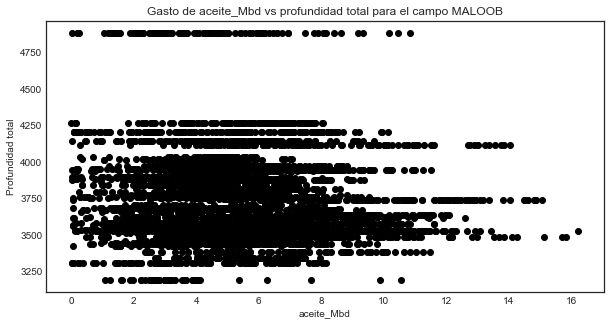

,Qi,b,di
count,74.00,74.00,74.00
mean,8.89,1.56,0.00
std,2.56,1.42,0.01
min,2.13,0.00,0.00
25%,7.55,0.00,0.00
50%,8.67,1.96,0.00
75%,10.17,3.00,0.00
max,16.23,3.00,0.05


,Qi,b,di
0.10,5.93,0.00,0.00
0.50,8.67,1.96,0.00
0.90,11.83,3.00,0.01


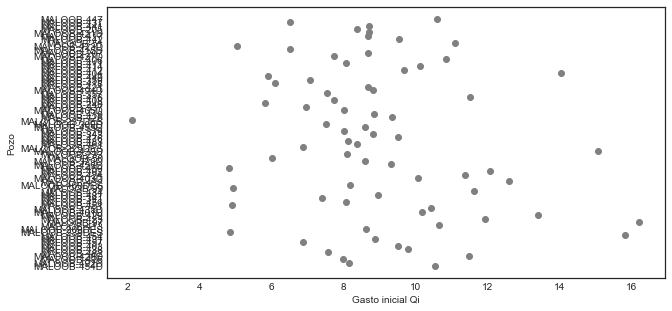

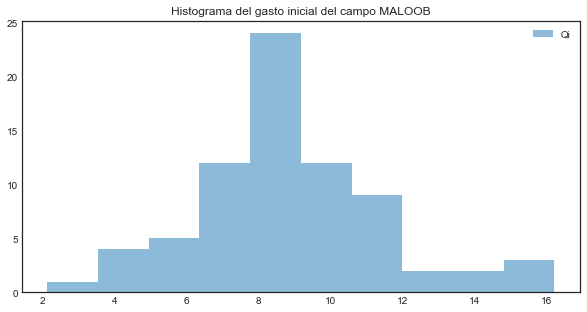

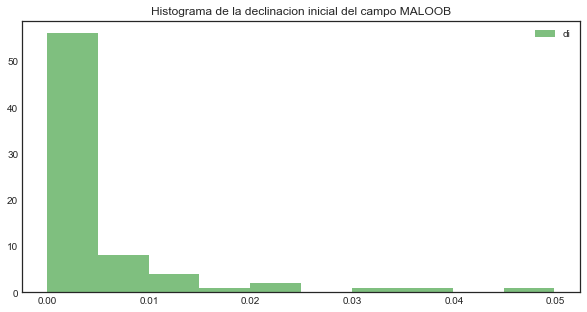

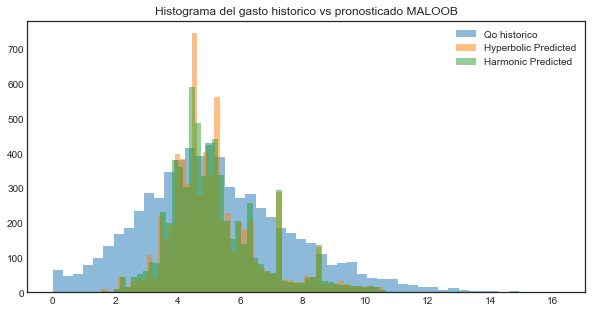

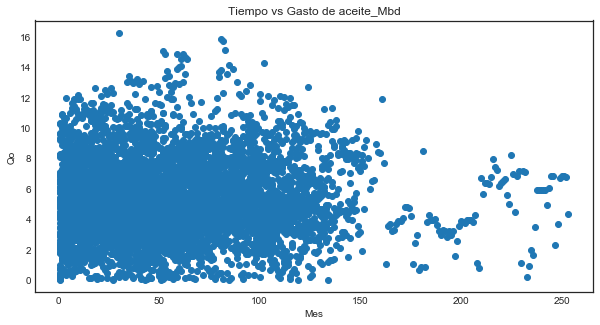

'Tiempo de procesamiento: 74.4150765999998 segundos'

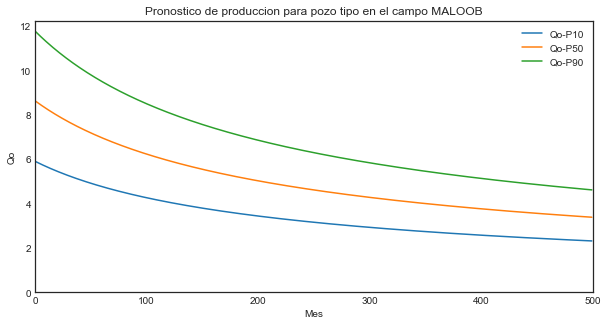

In [75]:
productividad('aceite_Mbd')

In [76]:
display(gasto_aceite.describe(),
        resultados.columns,
        resultados.describe(),
        gasto_aceite.head())

,Qi,b,di
count,74.00,74.00,74.00
mean,8.89,1.56,0.00
std,2.56,1.42,0.01
min,2.13,0.00,0.00
25%,7.55,0.00,0.00
50%,8.67,1.96,0.00
75%,10.17,3.00,0.00
max,16.23,3.00,0.05


Index(['Error Qo_hiperbolica', 'Error di_hiperbolica', 'Qi_hiperbolica', 'aceite_Mbd', 'agua_Mbd', 'ano_perforacion', 'asignacion', 'campo', 'clasificacion', 'condensado_Mbd', 'cuenca', 'days_online', 'di_hiperbolica', 'disponible', 'entidad', 'estado actual', 'fecha', 'first_oil', 'gas_asociado_MMpcd', 'gas_no_asociado_MMpcd', 'harmonica', 'hidrocarburo', 'hiperbolica', 'mes', 'pozo', 'profundidad_total', 'profundidad_vertical', 'trayectoria', 'ubicacion'], dtype='object')

,Error Qo_hiperbolica,Error di_hiperbolica,Qi_hiperbolica,aceite_Mbd,agua_Mbd,ano_perforacion,condensado_Mbd,days_online,di_hiperbolica,gas_asociado_MMpcd,gas_no_asociado_MMpcd,harmonica,hiperbolica,mes,profundidad_total,profundidad_vertical
count,"6,593.00","6,593.00","6,593.00","6,593.00","6,593.00","6,593.00","6,593.00","6,593.00","6,593.00","6,593.00","6,593.00","6,593.00","6,593.00","6,593.00","5,800.00","4,294.00"
mean,inf,inf,5.94,5.22,0.04,"2,009.50",0.00,"1,716.01",0.00,1.82,0.00,5.22,5.22,55.42,"3,755.52","2,405.79"
std,nan,nan,1.88,2.42,0.21,3.64,0.00,"1,270.11",0.01,1.30,0.00,1.50,1.51,40.28,301.13,"1,615.40"
min,0.13,0.00,2.13,0.00,0.00,"1,998.00",0.00,0.00,0.00,0.00,0.00,1.59,1.56,1.00,"3,190.00",74.00
25%,0.29,0.00,4.52,3.61,0.00,"2,008.00",0.00,700.00,0.00,1.05,0.00,4.26,4.23,23.00,"3,528.00",85.00
50%,0.39,0.00,5.33,4.99,0.00,"2,009.00",0.00,"1,491.00",0.00,1.57,0.00,4.93,4.92,48.00,"3,685.00","3,408.00"
75%,0.54,2.43,7.20,6.63,0.01,"2,012.00",0.00,"2,525.00",0.00,2.25,0.00,5.96,5.96,81.00,"3,936.00","3,485.00"
max,inf,inf,10.59,16.23,3.41,"2,019.00",0.00,"7,762.00",0.05,21.87,0.00,10.83,10.57,253.00,"4,882.00","4,300.00"


,Pozo,Qi,b,di
0,MALOOB-454D,10.55,0.00,0.00
0,MALOOB-492D,8.16,2.41,0.04
0,MALOOB-425,7.97,3.00,0.00
0,MALOOB-428D,11.49,2.88,0.01
0,MALOOB-482,7.58,2.91,0.00


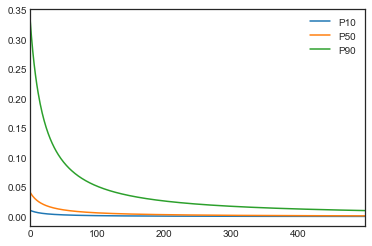

In [17]:
q10=gasto_aceite.Qi.quantile(.1)
q50=gasto_aceite.Qi.quantile(.5)
q90=gasto_aceite.Qi.quantile(.9)

d10=gasto_aceite.di.quantile(.1)
d50=gasto_aceite.di.quantile(.5)
d90=gasto_aceite.di.quantile(.9)
d=gasto_aceite.di.mean()
b=gasto_aceite.b.mean()

perfil=pd.DataFrame()
for x in df:
    
    perfil['mes']=x
    perfil['P10']=(q10/((1.0+b*d*df.periodo)**(1.0/b)))
    perfil['P50']=(q50/((1.0+b*d*df.periodo)**(1.0/b)))
    perfil['P90']=(q90/((1.0+b*d*df.periodo)**(1.0/b)))


perfil.plot()

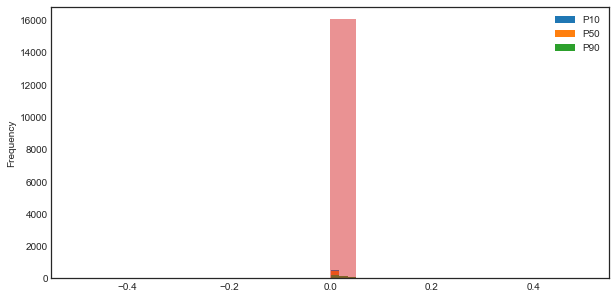

In [18]:
perfil.plot.hist(figsize=(10,5),bins=20)
resultados.aceite_Mbd.plot.hist(figsize=(10,5),bins=20,alpha=0.5)

In [150]:
oil=resultados[['pozo','aceite_Mbd','mes']]

df2=oil.groupby('mes').mean().reset_index()

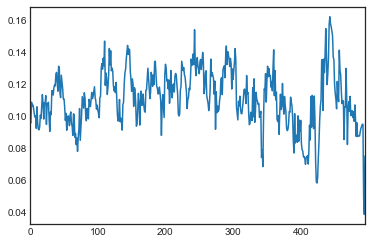

In [151]:
df2.aceite_Mbd.plot()

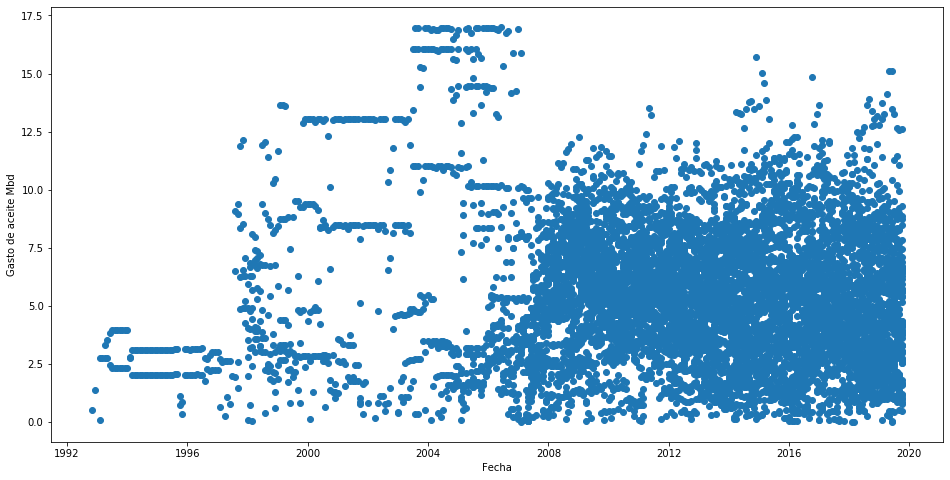

In [21]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(campo.fecha,campo.aceite_Mbd)
ax.set_xlabel('Fecha')
ax.set_ylabel('Gasto de aceite Mbd')
plt.show()